In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.3.0


# 데이터 불러오기, 전처리

fashion_mnist 데이터는 우리가 인터넷에서 따로 다운받을 필요 없이,tf.keras 안에 있는 datasets에 이미 들어가 있어서 꺼내기만 하면 됩니다.

꺼내서 load_data()로 데이터를 로딩해 볼 텐데, 특히 이번에는 분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요없습니다. 즉, 우리가 MNIST 데이터로 분류 문제를 풀었을 때 필요했던 y_train, y_test에 해당하는 데이터를 쓰지 않는 거죠. 그렇기 때문에 코드에서 _ (언더스코어)로 해당 데이터들은 무시하도록 하겠습니다.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.



In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x.shape

(60000, 28, 28)

다만 여기서 한 가지 추가되어야 할 것이 있습니다.
앞서 CNN(합성곱) 계층을 다룰 때 배웠듯, 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요합니다. 입력되는 이미지 데이터의 채널 수는 어떤 이미지냐에 따라 달라지는데요, 컬러 이미지의 경우 R, G, B 세 개의 채널이 있고, Gray Scale(흑백)의 경우 1개의 채널만 존재합니다. Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이죠. 따라서 데이터셋의 shape 마지막에 1을 추가해 주도록 하겠습니다.

In [7]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

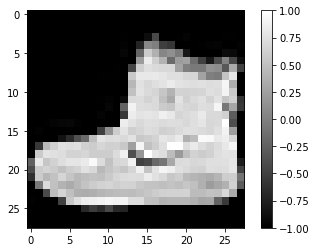

In [9]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

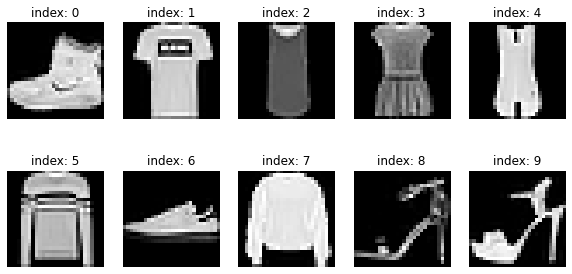

In [10]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

맨 첫 줄의 plt.figure(figsize=(10, 4))는 이미지의 전체 프레임의 크기를 결정합니다. 궁금하다면 한번 숫자를 바꿔서 실행시켜보세요!

또한 여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 볼 수 있습니다.
10개의 이미지를 2x5의 배열 형태로 보고 싶은 경우, plt.subplot(2, 5, index)로 작성하면 되는 거죠. index는 1부터 10까지 순서대로 바뀌어야 하니 for문에서 사용하는 i에 1을 i+1을 넣어주면 됩니다. (i는 range(10)으로 꺼냈으니 0~9의 숫자로 반복되죠)

추가적으로 plt.title('title') 함수를 이용해서 이미지에 제목으로 라벨 값을 넣어줬고, plt.axis('off') 함수로 불필요한 축을 지워서 깔끔하게 나타냈습니다.

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다.
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 미니배치 학습 이라고 합니다.

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

# DCGAN Model

오늘 우리가 구현해 볼 모델은 이전 스텝에서 언급했던 DCGAN(Deep Convolutional GAN)입니다. DCGAN은 GAN의 개념이 처음 소개된 1년 반 이후 발표된 논문으로서, 이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성을 이루어낸 첫번째 논문으로 평가받고 있습니다. 이후 발표된 수많은 GAN 기반 이미지 생성모델들은 대부분 DCGAN 모델을 발전시킨 형태라고 할 수 있으므로, 그 구조를 상세히 살펴보고 구현 연습을 해보는 것은 매우 의미있다고 생각됩니다.

### 생성자

In [13]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer. Transposed convolution layer (sometimes called Deconvolution).
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화 시켜줍니다. 또한 중간 층들의 활성화 함수는 모두 LeakyReLU를 사용하였습니다. 다만 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀값을 정규화 시켰던 데이터셋과 동일하게 하기 위함입니다.

Q1) 생성자의 입력 벡터는 어떤 형태입니까?   
A) 모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받습니다.


Q2) 처음 입력된 벡터는 어떤 레이어를 지나며, 첫 레이어를 지난 후의 shape는 어떤 형태입니까?
A) 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됩니다.

Q3) 첫 번째 레이어를 지난 후 벡터는 어떤 층을 지나게 됩니까? 이 레이어는 왜 필요합니까?   
A) 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.   
이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업입니다.

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [15]:
noise = tf.random.normal([1, 100])

In [16]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있습니다.

첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

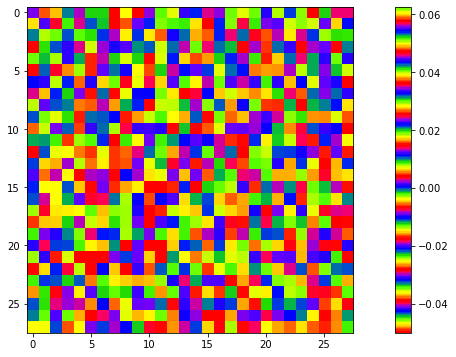

In [36]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

역시 -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있습니다.
아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었지만, 모델이 점차 학습해 나가며 제대로 된 이미지를 생성하기를 바라 봅니다.

### 판별자

In [19]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.   
첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됩니다.   

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [20]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [21]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00078745]], dtype=float32)>

# Loss function

tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화 한 후 알맞게 계산할 수 있습니다.

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.

fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)   
real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)   
그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.

In [23]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피 값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [26]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같습니다.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
> tf.Tensor([False, False, True, True])

(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
> tf.Tensor([0.0, 0.0, 1.0, 1.0])

(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
> 0.5


# Optimiser

중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 한 번에 16장을 생성하도록 하겠습니다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [28]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# Building training procedure

In [29]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동미분으로 계산하기 위해 with 구문 열기
(4) (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
(7) accuracy 계산 : fake_output, real_output으로 discriminator가
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보죠.
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [30]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정이 담겨 있는데, 어딘가 익숙하지 않나요?

바로 우리가 위에서 해봤던, subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화 하는 것이죠.

또한, plt에 저장되어 보여지는 이미지를 plt.savefig로 간단히 파일화 해서 저장합니다.
다만, 우리가 원하는 것은 generated_samples라는 폴더 아래에 저장하는 것이므로 try 구문을 이용해 폴더가 없는 상황에 에러가 발생하는 것을 방지합니다. 만약 폴더가 없어서 에러가 난다면, except 구문으로 들어가 os.mkdir('./generated_samples')로 폴더를 만든 후 파일을 저장할 수 있습니다.

학습과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없겠습니다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다. train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

In [31]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.

tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적입니다. 아주 오랜 시간동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 테니까요..!

checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장합니다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용하겠습니다.



In [32]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

자.. 이제 대망의 모델 학습입니다.

지금까지 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한 곳에 합치기만 하면 됩니다.

한번 확인해 볼까요!

In [33]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

여기서부터는 정말 별로 특별한 것이 없습니다. 우리가 생성된 샘플을 시각화하거나 원하는 시간을 출력하는 것뿐이니까요.
출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는대로 수정해서 마음에 드는 형태로 확인해 보세요!

그러면 모델을 저장하는 간격을 담당하는 save_every와 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정해준 후 훈련시켜 보도록 하겠습니다!

본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있습니다.
RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면, 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 최대한 GPU 환경에서 실습해 보는 것을 추천합니다.

이제 다음과 같이 train() 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있습니다!

In [34]:
save_every = 5
EPOCHS = 50

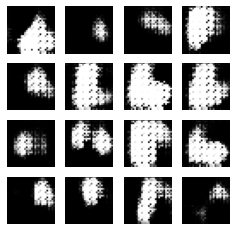

Epoch 2 | iter 151
Time for epoch 2 : 50 sec


KeyboardInterrupt: 

In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

학습이 성공적으로 진행되었나요?

만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻입니다.

보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다. 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!
과연 생성 모델이 이전에는 없던 새로운 디자인의 패션을 만들어내는 것을 확인할 수 있을 거에요..! (물론 시간은 그와 비례하게 늘어나겠죠..?)

어쩌면 단순히 학습수행 시간만 늘리는 것보다, 모델구조나 학습방법을 바꾸어 봐야 할 수도 있습니다. 그래프를 유심히 보면서 학습결과가 더이상 개선되고 있지 않은지 여부를 지속적으로 살펴봅시다.

# Visualisation

학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보겠습니다. 더욱 생생한 학습 진행 과정을 확인해 볼 수 있을 테니까요!

GIF 파일은 우리가 오래 전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있습니다.
imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식입니다.
아래 코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인할 수 있을 겁니다!

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif